<a href="https://colab.research.google.com/github/SeungHan0816/WM-811k_Wafermap_Practice/blob/main/WM_811k_Wafermap_DL_MNV3_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MobileNetV3 - Small 알고리즘 사용

# 0️⃣ 0단계. 패키지 설치 및 환경 변수 설정
!pip install kagglehub --quiet

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
print("환경 설정 완료")


환경 설정 완료


In [ ]:
# 1️⃣ 1단계. 라이브러리 임포트 및 디바이스 설정
import kagglehub
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import mobilenet_v3_small
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import albumentations as A
import torch.nn.functional as F

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# 2️⃣ 2단계. 데이터 로딩 및 전처리
path = kagglehub.dataset_download('qingyi/wm811k-wafer-map')
df = pd.read_pickle(os.path.join(path, "LSWMD.pkl"))

def safe_extract_failure_type(x):
    while isinstance(x, (list, np.ndarray)):
        if isinstance(x, np.ndarray) and x.shape == ():
            x = x.item(); continue
        if len(x) == 0:
            return 'none'
        x = x[0]
    return x if isinstance(x, str) else str(x)

df['failureType'] = df['failureType'].apply(safe_extract_failure_type)

failure_map = {
    'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3,
    'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7,
    'none':8
}
df['label'] = df['failureType'].map(failure_map)
df = df[df['label'] != 8].reset_index(drop=True)

for col in ['waferIndex','lotName','trianTestLabel']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

print("데이터 로딩 및 전처리 완료")


데이터 로딩 및 전처리 완료


In [ ]:
# 3️⃣ 3단계. Custom Dataset 클래스 정의 (128×128 리사이즈)
class WaferDataset(Dataset):
    def __init__(self, df):
        self.maps   = df['waferMap'].values
        self.labels = df['label'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.maps[idx].astype(np.float32)
        img = resize(img, (128, 128), order=0, preserve_range=True).astype(np.float32)
        img = np.repeat(img[None], 3, axis=0) / 2.0
        return torch.tensor(img), torch.tensor(self.labels[idx], dtype=torch.long)

print("Custom Dataset 클래스 정의 완료")


Custom Dataset 클래스 정의 완료


In [ ]:
# 4️⃣ 4단계. 데이터 분할 및 통계 출력, DataLoader 구성
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)
train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(f"🔹 전체 샘플 수: {len(df)}개")
print("📊 전체 클래스별 분포:")
for l, c in df['label'].value_counts().sort_index().items():
    print(f"  클래스 {l}: {c}개 ({c/len(df)*100:.2f}%)")

print(f"\n🟢 학습 데이터 수: {len(train_df)}개")
print("📘 학습 데이터 클래스 분포:")
for l, c in train_df['label'].value_counts().sort_index().items():
    print(f"  클래스 {l}: {c}개 ({c/len(train_df)*100:.2f}%)")

print(f"\n🔵 테스트 데이터 수: {len(test_df)}개")
print("📙 테스트 데이터 클래스 분포:")
for l, c in test_df['label'].value_counts().sort_index().items():
    print(f"  클래스 {l}: {c}개 ({c/len(test_df)*100:.2f}%)")

label_counts   = np.bincount(train_df['label'])
class_weights  = 1.0 / label_counts
sample_weights = class_weights[train_df['label'].values]
sampler        = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)

train_loader = DataLoader(
    WaferDataset(train_df), batch_size=8, sampler=sampler, num_workers=2
)
test_loader  = DataLoader(
    WaferDataset(test_df), batch_size=8, shuffle=False, num_workers=2
)

print("데이터 분할 및 DataLoader 구성 완료")


🔹 전체 샘플 수: 25519개
📊 전체 클래스별 분포:
  클래스 0: 4294개 (16.83%)
  클래스 1: 555개 (2.17%)
  클래스 2: 5189개 (20.33%)
  클래스 3: 9680개 (37.93%)
  클래스 4: 3593개 (14.08%)
  클래스 5: 866개 (3.39%)
  클래스 6: 1193개 (4.67%)
  클래스 7: 149개 (0.58%)

🟢 학습 데이터 수: 20415개
📘 학습 데이터 클래스 분포:
  클래스 0: 3435개 (16.83%)
  클래스 1: 444개 (2.17%)
  클래스 2: 4151개 (20.33%)
  클래스 3: 7744개 (37.93%)
  클래스 4: 2874개 (14.08%)
  클래스 5: 693개 (3.39%)
  클래스 6: 955개 (4.68%)
  클래스 7: 119개 (0.58%)

🔵 테스트 데이터 수: 5104개
📙 테스트 데이터 클래스 분포:
  클래스 0: 859개 (16.83%)
  클래스 1: 111개 (2.17%)
  클래스 2: 1038개 (20.34%)
  클래스 3: 1936개 (37.93%)
  클래스 4: 719개 (14.09%)
  클래스 5: 173개 (3.39%)
  클래스 6: 238개 (4.66%)
  클래스 7: 30개 (0.59%)
데이터 분할 및 DataLoader 구성 완료


In [ ]:
# 5️⃣ 5단계. 모델 정의 (MobileNetV3-Small, backbone 고정 + 일부 Unfreeze)
model = mobilenet_v3_small(pretrained=True)

# backbone 완전 고정
for param in model.features.parameters():
    param.requires_grad = False

# 마지막 블록(예: index ≥12)만 Unfreeze
for i, module in enumerate(model.features):
    requires = (i >= 12)
    for p in module.parameters():
        p.requires_grad = requires

# classifier 교체
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Linear(in_f, 8)
model = model.to(device)

print("모델 정의 완료")


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 13.5MB/s]

모델 정의 완료


In [ ]:
# 6️⃣ 6단계. 손실함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float32).to(device)
)
optimizer = torch.optim.Adam(
    model.classifier[3].parameters(), lr=1e-3
)

print("손실함수 및 옵티마이저 설정 완료")


손실함수 및 옵티마이저 설정 완료


In [ ]:
# 7️⃣ 7단계. 학습 루프
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)
        loss_sum += loss.item()

    print(f"[Epoch {epoch:02d}] Loss: {loss_sum/total:.4f} | Acc: {100*correct/total:.2f}%")


[Epoch 01] Loss: 0.0607 | Acc: 64.15%
[Epoch 02] Loss: 0.0485 | Acc: 68.97%
[Epoch 03] Loss: 0.0478 | Acc: 69.41%
[Epoch 04] Loss: 0.0484 | Acc: 69.88%
[Epoch 05] Loss: 0.0469 | Acc: 69.80%
[Epoch 06] Loss: 0.0457 | Acc: 70.14%
[Epoch 07] Loss: 0.0468 | Acc: 69.93%
[Epoch 08] Loss: 0.0489 | Acc: 69.42%
[Epoch 09] Loss: 0.0492 | Acc: 70.10%
[Epoch 10] Loss: 0.0456 | Acc: 70.99%
[Epoch 11] Loss: 0.0453 | Acc: 70.35%
[Epoch 12] Loss: 0.0478 | Acc: 69.91%
[Epoch 13] Loss: 0.0461 | Acc: 70.67%
[Epoch 14] Loss: 0.0457 | Acc: 70.65%
[Epoch 15] Loss: 0.0464 | Acc: 70.06%
[Epoch 16] Loss: 0.0481 | Acc: 70.31%
[Epoch 17] Loss: 0.0466 | Acc: 70.04%
[Epoch 18] Loss: 0.0470 | Acc: 70.33%
[Epoch 19] Loss: 0.0466 | Acc: 70.46%
[Epoch 20] Loss: 0.0470 | Acc: 70.55%


In [ ]:
# 8️⃣ 8단계. 평가 및 분류 리포트 출력
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.8054    0.6938    0.7455       859
           1     0.2936    0.8649    0.4384       111
           2     0.7054    0.3805    0.4944      1038
           3     0.9825    0.8709    0.9233      1936
           4     0.5102    0.2434    0.3296       719
           5     0.3898    0.9306    0.5495       173
           6     0.2074    0.8277    0.3316       238
           7     0.4727    0.8667    0.6118        30

    accuracy                         0.6528      5104
   macro avg     0.5459    0.7098    0.5530      5104
weighted avg     0.7556    0.6528    0.6699      5104



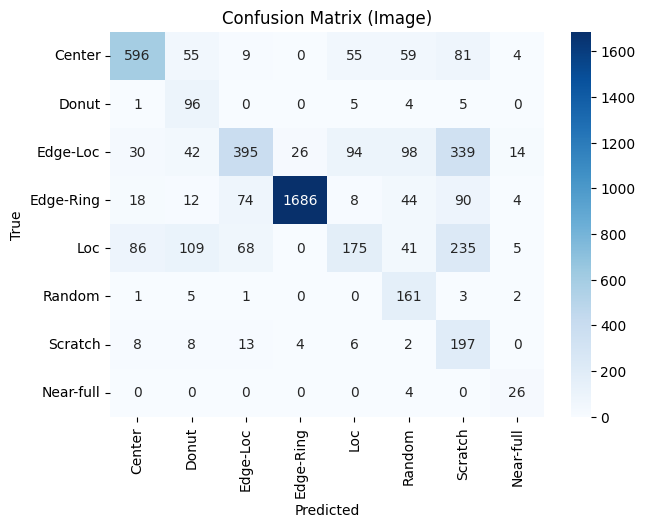

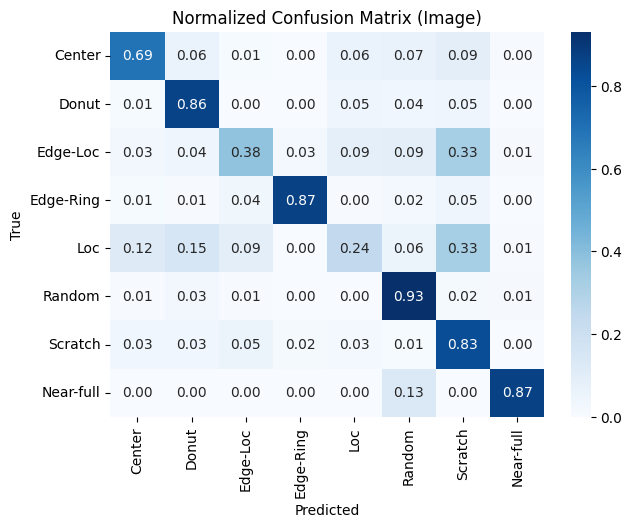

Confusion Matrix Array:


,Center,Donut,Edge-Loc,Edge-Ring,Loc,Random,Scratch,Near-full
Center,596,55,9,0,55,59,81,4
Donut,1,96,0,0,5,4,5,0
Edge-Loc,30,42,395,26,94,98,339,14
Edge-Ring,18,12,74,1686,8,44,90,4
Loc,86,109,68,0,175,41,235,5
Random,1,5,1,0,0,161,3,2
Scratch,8,8,13,4,6,2,197,0
Near-full,0,0,0,0,0,4,0,26



Normalized Confusion Matrix Array:


,Center,Donut,Edge-Loc,Edge-Ring,Loc,Random,Scratch,Near-full
Center,0.693830,0.064028,0.010477,0.000000,0.064028,0.068685,0.094296,0.004657
Donut,0.009009,0.864865,0.000000,0.000000,0.045045,0.036036,0.045045,0.000000
Edge-Loc,0.028902,0.040462,0.380539,0.025048,0.090559,0.094412,0.326590,0.013487
Edge-Ring,0.009298,0.006198,0.038223,0.870868,0.004132,0.022727,0.046488,0.002066
Loc,0.119611,0.151599,0.094576,0.000000,0.243394,0.057024,0.326843,0.006954
Random,0.005780,0.028902,0.005780,0.000000,0.000000,0.930636,0.017341,0.011561
Scratch,0.033613,0.033613,0.054622,0.016807,0.025210,0.008403,0.827731,0.000000
Near-full,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.866667


In [ ]:
# 9️⃣ 9단계. 혼동 행렬 시각화 및 배열 출력
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
class_names = [
    'Center','Donut','Edge-Loc','Edge-Ring',
    'Loc','Random','Scratch','Near-full'
]

# (1) 이미지로 시각화
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (Image)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix (Image)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# (2) 배열(표) 형태로 출력
import pandas as pd
print("Confusion Matrix Array:")
display(pd.DataFrame(cm, index=class_names, columns=class_names))

print("\nNormalized Confusion Matrix Array:")
display(pd.DataFrame(cm_norm, index=class_names, columns=class_names))
